In [1]:
import os
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.signal as sig
import scipy.io as spio


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import community
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

sys.path.append("../../../code/ndsvae/")
import ndsvae as ndsv

sys.path.append("../")
import util
import plotutils as pu


%matplotlib inline

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
configs = ["ns_3_mreg_1_msub_2_nf_32", "ns_3_mreg_2_msub_2_nf_32",
           "ns_3_mreg_3_msub_2_nf_32", "ns_3_mreg_4_msub_2_nf_32", "ns_3_mreg_5_msub_2_nf_32"]

conn = "linw"
preproc = "dicer"
modelname = "AB"

nconf = len(configs)

In [4]:
ds = ndsv.Dataset.from_file(f"../run/hcp/hcp_{conn}_{preproc}/dataset.npz")
runs = [util.select_run(f"hcp_{conn}_{preproc}", modelname, config, [0,1], "hcp") for config in configs]
direcs = [f"../run/hcp/hcp_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}" 
         for config, run in zip(configs, runs)]
paramss = [ndsv.Params.from_file(os.path.join(direc, "parameters.npz")) for direc in direcs]

In [5]:
nsub, nreg, _, nt = ds.y.shape
subjects = np.r_[:nsub]
regions = np.r_[:nreg]

In [6]:
runs

[0, 1, 0, 0, 0]

## Calculate KL

In [7]:
paramss[0].thetareg.shape

(8, 68, 1, 2)

In [8]:
nsamples = 10

maxmreg = 5
kl = np.full((nconf, nsub, nreg, maxmreg), np.nan)

for (iconf, isub, ireg) in itertools.product(range(nconf), range(nsub), range(nreg)):
    treg = paramss[iconf].thetareg[isub,ireg,:,:]
    mreg = treg.shape[0]

    tregmu  = treg[:,0]
    tregstd = treg[:,1]
    kl[iconf,isub,ireg,:mreg] = (np.log(1./tregstd) + (tregstd**2 + tregmu**2)/2. - 0.5)

In [9]:
print("   mreg=1   mreg=2   mreg=3   mreg=4   mreg=5")
print("---------------------------------------------")

for j in range(maxmreg):
    for i in range(nconf): 
        klconf = -np.sort([np.mean(-kl[i,:,:,j]) for j in range(maxmreg)])
        
        print(f"   {klconf[j]:6.3f}", end='')
    print("")

   mreg=1   mreg=2   mreg=3   mreg=4   mreg=5
---------------------------------------------
    2.911    2.767    2.731    2.731    2.719
      nan    1.958    1.930    1.949    1.935
      nan      nan    0.789    0.836    0.001
      nan      nan      nan    0.000    0.000
      nan      nan      nan      nan    0.000


## Plot the effect

In [10]:
iconf = 2

config = configs[iconf]
run = runs[iconf]
mreg = paramss[iconf].thetareg.shape[2]
order = np.argsort(np.mean(-kl[iconf,:,:,:], axis=(0,1)))[:mreg]

model = util.get_model(modelname, config, ds)
model.load_weights(f"../run/hcp/hcp_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}/fit/model")

In [11]:
def simulate(x0, eta, etaobs, u, us, treg, tsub):
    # Set the dimensions: (nsamples, m)
    x0 = x0[None,:]
    treg = treg[None,:]
    tsub = tsub[None,:]

    # Set the dimensions: (nsamples, nt, 1)
    u = u[None,:,None]
    us = us[None,:,None]

    eta = eta[None,:,:]

    x = model.source_model.simulate(x0, eta, u, us, treg, tsub, nt).numpy()
    y = (np.tensordot(x[0], model.Ap.numpy(), axes=[[1],[1]])[:,0] 
             + model.bp.numpy() + np.exp(0.5 * model.olv)*etaobs)
    
    return x[0].T, y

In [12]:
order

array([1, 2, 0])

In [13]:
# Simulate the data

np.random.seed(42)
n = 5

x0 = 0*np.ones(model.ns)
eta = np.random.normal(0, 1, size=(nt, model.ns))
etaobs = np.random.normal(0, 1, size=(nt))

t = np.linspace(0,1200,1200)
u_zero  = np.zeros(nt)
us_zero = np.zeros(nt)
u_sin   = 2*np.sin(0.4*t/(2*np.pi))
us_sin  = 2*np.sin(0.4*t/(2*np.pi))
    

tregs = np.zeros((mreg, n, mreg))       
tregs[0,:,order[0]] = np.linspace(-3,3,n)
tregs[1,:,order[1]] = np.linspace(-3,3,n)
tregs[2,:,order[2]] = np.linspace(-3,3,n)
   
tsub = np.array([0,0])
    
ys = np.zeros((mreg, n, nt))
    
for i in range(n):
    _, ys[0,i,:] = simulate(x0, eta, etaobs, u_zero, us_zero, tregs[0,i], tsub)   
    _, ys[1,i,:] = simulate(x0, eta, etaobs, u_zero, us_sin, tregs[1,i], tsub)
    _, ys[2,i,:] = simulate(x0, eta, etaobs, u_sin, us_zero, tregs[2,i], tsub)
    
    # for j in range(3):
    #     _, ys[j,i,:] = simulate(x0, eta, etaobs, u_zero, us_sin, tregs[j,i], tsub)

In [67]:
def plot_parampoints(ax, x):
    plt.sca(ax)
    ax.scatter(x[:,0], x[:,1], x[:,2], c=np.r_[:x.shape[0]], cmap='viridis', vmin=0, vmax=x.shape[0],
               alpha=1., s=20)
    ax.plot([-4, 4], [0,0], [0,0], color='k', lw=0.5)
    ax.plot([0,0], [-4,4], [0,0], color='k', lw=0.5)
    ax.plot([0,0], [0,0], [-4,4], color='k', lw=0.5)
    ax.set_axis_off()
    
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-2,2])
    
    ax.text(4,0,0, r"$\theta^r_1$")
    ax.text(0,4,0, r"$\theta^r_2$")
    ax.text(0,0,4, r"$\theta^r_3$")

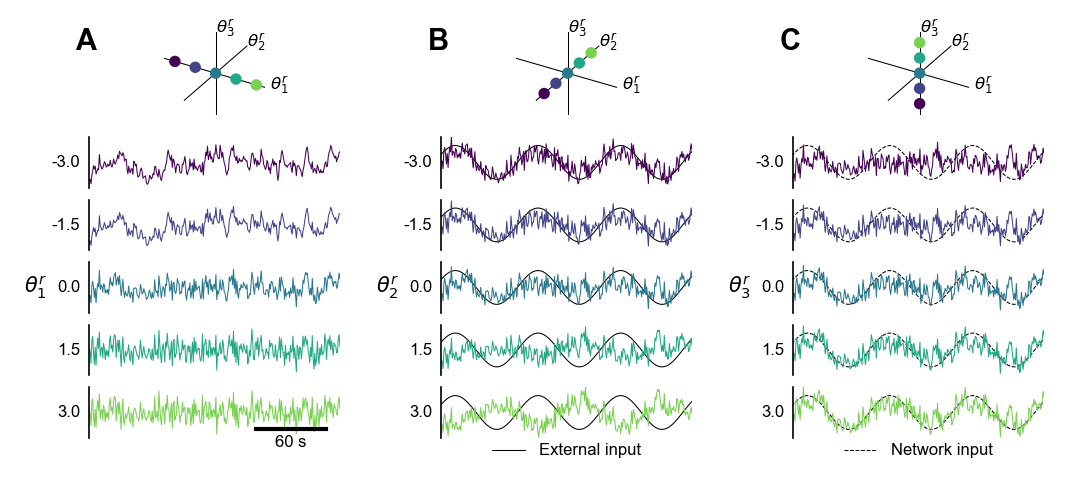

In [68]:
cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=0, vmax=n)

fig = plt.figure(figsize=(7, 3.), dpi=150)

gs = matplotlib.gridspec.GridSpec(6, 3, hspace=0.2, wspace=0.4, left=0.07, right=0.98, bottom=0.06, top=0.98,
                                 height_ratios=[2,1,1,1,1,1])

for i in range(3):
    ax = fig.add_subplot(gs[0,i], projection='3d', proj_type='ortho')
    plot_parampoints(ax, tregs[i][:,order])
    

axes = []
for i in range(3):
    for j in range(n):
        ax = plt.subplot(gs[j+1,i])
        # plt.title(f"$\\theta^r_{i+1} = {tregs[i,j,order[i]]:.2f}$")
        # plt.text(560, 3.0, f"$\\theta^r_{i+1}$ = {tregs[i,j,order[i]]:.1f}", ha='center',  va='center', fontsize=8)
        plt.plot(ys[i,j,:], color=cmap(norm(j)), lw=0.5)
        
        if i == 1:
            plt.plot(us_sin, color='k', lw=0.5, zorder=-1, label="External input")
        if i == 2:
            plt.plot(u_sin, color='k', ls='--', lw=0.5, zorder=-2, label="Network input")
        
        
        plt.xlim(500,800)
                
        plt.ylim(-3,3)
        # plt.yticks([-2, 2])
        plt.yticks([])        
        # plt.ylabel(f"$\\theta^r_{i+1}$ = {tregs[i,j,order[i]]:.1f}                   ", rotation='horizontal')
        plt.text(490, 0, f"{tregs[i,j,order[i]]:.1f}", fontsize=8, ha='right', va='center')
        
        if j == 2:
            plt.text(450, 0, f"$\\theta^r_{i+1}$", fontsize=10, ha='right', va='center')
        
        plt.xticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        if i in [1,2] and j == n-1:
            plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.7), frameon=False)
            
        if j == 0:
            axes.append(ax)
            
        if i == 0 and j == n-1:
            dt = ds.t[1]-ds.t[0]
            nn = 60./dt
            plt.plot([700,700+nn], [-2,-2], lw=2, color='k')
            plt.text(700+nn/2, -2.6, "60 s", ha='center', va='top', fontsize=8)
    
pu.Background(visible=False)
pu.add_panel_labels(fig, axes, xs=-0.05, ys=2.6, fontsize=14)
plt.savefig("./img/Fig_ParamEffect.pdf")